In [7]:
import sys
import gym
import random
import numpy as np
from collections import defaultdict

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.

Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with dealer having one face up and one face down card, while
player having two face up cards. (Virtually for all Blackjack games today).
The player can **request additional cards (hit=1)** until they decide to **stop
(stick=0)** or **exceed 21 (bust)**.

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

In [26]:
def to_index(S):
    return tuple(int(x) for x in S)

Each state is a 3-tuple of:

the player's current sum $\in \{0, 1, \ldots, 31\}$,
the dealer's face up card $\in \{1, \ldots, 10\}$, and
whether or not the player has a usable ace (no $=0$, yes $=1$).
The agent has two potential actions:

* STICK = 0
* HIT = 1


* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


In [17]:
env = gym.make('Blackjack-v0', natural=True)

for i_episode in range(5):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(15, 9, False)
End game! Reward:  -1.0
You lost :(

(13, 10, False)
End game! Reward:  -1.0
You lost :(

(21, 8, True)
End game! Reward:  1.5
You won :)

(20, 4, False)
End game! Reward:  -1.0
You lost :(

(6, 10, False)
End game! Reward:  -1.0
You lost :(



## Part 1

**1. Рассмотрим очень простую стратегию:**
* **говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко**
* **во всех остальных случаях говорить hit**

**Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.**

In [19]:
env = gym.make('Blackjack-v0', natural=True)

In [20]:
env.seed(42);

In [21]:
HIT = 1
STAND = 0

In [22]:
def simple_policy(observation):
    score, _, _ = observation
    return STAND if score >= 19 else HIT

Для начала оценим средний выигрыш в игре по данной стратегии (усредняя по начальным состояниям)

In [23]:
N_EXPERIMENTS = 1_000_000
# N_EXPERIMENTS = 100_000

In [24]:
%%time

reward_history = []
step_history = []
for i in range(N_EXPERIMENTS):
    
    done = False
    observation = env.reset()
    step = 0
    
    while not done:
        action = simple_policy(observation)
        observation, reward, done, info = env.step(action)
        step += 1
        
    reward_history.append(reward)
    step_history.append(step)

CPU times: user 48.6 s, sys: 249 ms, total: 48.9 s
Wall time: 49.6 s


In [25]:
print(f"Средняя награда: {np.mean(reward_history): .5f}")

Средняя награда: -0.17984


In [26]:
print(f'Среднее число шагов: {np.mean(step_history): .5f}')

Среднее число шагов:  1.74512


In [27]:
print(f"Средний процент выигрышей: {np.mean(np.array(reward_history) > 0): .5f}")

Средний процент выигрышей:  0.36188


**Question: Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.**

**Answer: -0.17984**

----------------------------------

**2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.**


**TD-обучение: off-policy (Q-обучение)** 

In [177]:
# alpha=0.25
# epsilon=0.5
# gamma=0.1

alpha=0.2
epsilon=0.5
gamma=0.1

In [186]:
%%time

Q_td = np.random.rand(
    *(x.n for x in env.observation_space), env.action_space.n
) * 2 - 1

for i in range(N_EXPERIMENTS):

    observation = env.reset()
    done = False

    while not done:
        a_star = Q_td[to_index(observation)].argmax()
        ps = np.ones(env.action_space.n) * epsilon / env.action_space.n
        ps[a_star] = 1 - epsilon + epsilon / env.action_space.n
        At = np.random.choice(np.arange(env.action_space.n), p = ps / ps.sum())

        St = observation
        observation, reward, done, info = env.step(At)
        Q_td[(*to_index(St), At)] += alpha * (reward + gamma * Q_td[to_index(observation)].max() - Q_td[(*to_index(St), At)])

CPU times: user 2min 33s, sys: 1.73 s, total: 2min 34s
Wall time: 2min 40s


In [179]:
pi = Q_td.argmax(axis=-1)

In [180]:
%%time

reward_history = []
step_history = []
for i in range(N_EXPERIMENTS):
    
    done = False
    observation = env.reset()
    step = 0
    
    while not done:
        action = pi[to_index(observation)]
        observation, reward, done, info = env.step(action)
        step += 1
        
    reward_history.append(reward)
    step_history.append(step)
    

CPU times: user 53.9 s, sys: 568 ms, total: 54.4 s
Wall time: 56.3 s


In [181]:
print(f"Средняя награда: {np.mean(reward_history): .5f}")

Средняя награда: -0.07786


In [182]:
print(f'Среднее число шагов: {np.mean(step_history): .5f}')

Среднее число шагов:  1.56947


In [183]:
print(f"Средний процент выигрышей: {np.mean(np.array(reward_history) > 0): .5f}")

Средний процент выигрышей:  0.40656


In [184]:
cum_average_reward = np.cumsum(reward_history) / np.arange(1, len(reward_history) + 1)

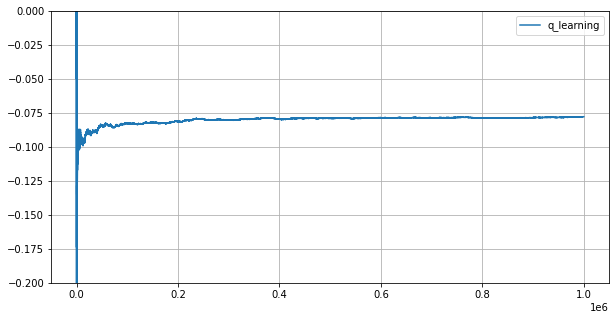

In [185]:
plt.figure(figsize=(10, 5))
plt.plot(cum_average_reward, label="q_learning")
plt.ylim([-0.2, 0])
plt.grid()
plt.legend();

## Part 2

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. 

Итак, у игрока появляется дополнительное действие:

* **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [32]:
env = gym.make('Blackjack-v0', natural=True)

In [33]:
env.seed(42);

In [34]:
def double_step(self, action):
    assert self.action_space.contains(action)
    if action == 1:  # hit: add a card to players hand and return
        self.player.append(draw_card(self.np_random))
        if is_bust(self.player):
            done = True
            reward = -1.
        else:
            done = False
            reward = 0.
    elif action == 0:  # stick: play out the dealers hand, and score
        done = True
        while sum_hand(self.dealer) < 17:
            self.dealer.append(draw_card(self.np_random))
        reward = cmp(score(self.player), score(self.dealer))
        if self.natural and is_natural(self.player) and reward == 1.:
            reward = 1.5
    elif action == 2:
        self.player.append(draw_card(self.np_random))
        done = True
        while sum_hand(self.dealer) < 17:
            self.dealer.append(draw_card(self.np_random))
        reward = cmp(score(self.player), score(self.dealer))
        if self.natural and is_natural(self.player) and reward == 1.:
            reward = 1.5
        reward *= 2
    return self._get_obs(), reward, done, {}

In [35]:
from gym.envs.toy_text.blackjack import *

In [36]:
env.step = double_step.__get__(env)
env.action_space = spaces.Discrete(3)

In [37]:
N_EXPERIMENTS = 1_000_000
# N_EXPERIMENTS = 100_000

In [38]:
# alpha=0.25
# epsilon=0.5
# gamma=0.1

alpha=0.2
epsilon=0.5
gamma=0.1

In [160]:
%%time

Q_td = np.random.rand(
    *(x.n for x in env.observation_space), env.action_space.n
) * 2 - 1

for i in range(N_EXPERIMENTS):

    observation = env.reset()
    done = False

    while not done:
        a_star = Q_td[to_index(observation)].argmax()
        ps = np.ones(env.action_space.n) * epsilon / env.action_space.n
        ps[a_star] = 1 - epsilon + epsilon / env.action_space.n
        At = np.random.choice(np.arange(env.action_space.n), p = ps / ps.sum())

        St = observation
        observation, reward, done, info = env.step(At)
        Q_td[(*to_index(St), At)] += alpha * (reward + gamma * Q_td[to_index(observation)].max() - Q_td[(*to_index(St), At)])

CPU times: user 2min 30s, sys: 2.23 s, total: 2min 32s
Wall time: 2min 39s


In [161]:
pi = Q_td.argmax(axis=-1)

In [162]:
%%time

reward_history = []
step_history = []
for i in range(N_EXPERIMENTS):
    
    done = False
    observation = env.reset()
    step = 0
    
    while not done:
        action = pi[to_index(observation)]
        observation, reward, done, info = env.step(action)
        step += 1
        
    reward_history.append(reward)
    step_history.append(step)

CPU times: user 54.7 s, sys: 535 ms, total: 55.2 s
Wall time: 57.3 s


In [163]:
print(f"Средняя награда: {np.mean(reward_history): .5f}")

Средняя награда: -0.06241


In [164]:
print(f'Среднее число шагов: {np.mean(step_history): .5f}')

Среднее число шагов:  1.47554


In [165]:
print(f"Средний процент выигрышей: {np.mean(np.array(reward_history) > 0): .5f}")

Средний процент выигрышей:  0.41197


In [166]:
cum_average_reward = np.cumsum(reward_history) / np.arange(1, len(reward_history) + 1)

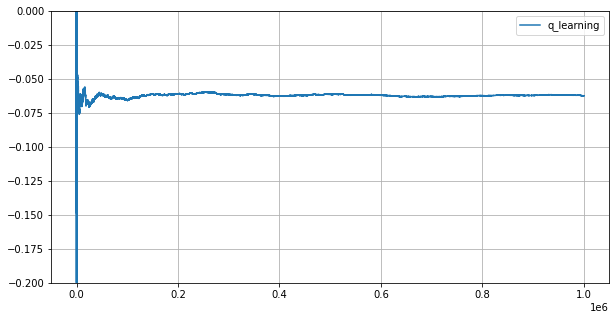

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(cum_average_reward, label="q_learning")
plt.ylim([-0.2, 0])
plt.grid()
plt.legend();

## Part 3

**Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде**

**[система подсчёта «Плюс-минус»](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA)** 

* 2, 3, 4, 5, 6: будет +1
* 7, 8, 9: будет 0
* 10, В, Д, К, Т: будет −1

In [146]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_hand(deck):
    return [draw_card(deck), draw_card(deck)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


scores_dict = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 1: -1, 10: -1}


class BlackjackEnv(gym.Env):

    def __init__(self, natural=False):
        
        self.deck = random.sample(initial_deck, len(initial_deck))
        self.count_statistic = 0
        
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(3)
        ))
        
        self.seed()
        self.natural = natural
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            cur_card = self.draw_card(self.np_random)
            self.update_card_count(cur_card)
            self.player.append(cur_card)
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.deck))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            for card in self.dealer[1:]:
                self.update_card_count(card)
        else:
            self.player.append(self.draw_card(self.deck))
            done = True
            if is_bust(self.player):
                reward = -1.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.deck))
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.:
                    reward = 1.5
            reward *= 2
            for card in self.dealer[1:]:
                self.update_card_count(card)
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.get_count_statistics())

    def reset(self):
        if len(self.deck) < 15:
            self.deck = random.sample(initial_deck, len(initial_deck))
            self.coutn_stat = 0
            
        self.dealer = draw_hand(self.deck)
        self.player = draw_hand(self.deck)
        
        for card in [self.dealer[0], self.player[0], self.player[1]]:
            self.update_card_count(card)
        
        return self._get_obs()
    
    def get_count_statistics(self):
        if self.count_statistic > 0:
            return 2
        elif self.count_statistic == 0:
            return 1
        return 0
    
    def update_card_count(self, card):
        self.count_statistic += scores_dict.get(card, 0)
        
    def draw_card(self, deck):
        card = self.deck[0]
        self.deck.remove(card)
        return card

In [135]:
env = BlackjackEnv(natural=True)

In [136]:
N_EXPERIMENTS = 1_000_000
# N_EXPERIMENTS = 100_000

In [137]:
# alpha=0.25
# epsilon=0.5
# gamma=0.1

alpha=0.2
epsilon=0.5
gamma=0.1

In [138]:
%%time

Q_td = np.random.rand(
    *(x.n for x in env.observation_space), env.action_space.n
) * 2 - 1

for i in range(N_EXPERIMENTS):

    observation = env.reset()
    done = False

    while not done:
        a_star = Q_td[to_index(observation)].argmax()
        ps = np.ones(env.action_space.n) * epsilon / env.action_space.n
        ps[a_star] = 1 - epsilon + epsilon / env.action_space.n
        At = np.random.choice(np.arange(env.action_space.n), p = ps / ps.sum())

        St = observation
        observation, reward, done, info = env.step(At)
        Q_td[(*to_index(St), At)] += alpha * (reward + gamma * Q_td[to_index(observation)].max() - Q_td[(*to_index(St), At)])

CPU times: user 2min 5s, sys: 1.8 s, total: 2min 6s
Wall time: 2min 11s


In [139]:
pi = Q_td.argmax(axis=-1)

In [140]:
%%time

reward_history = []
step_history = []
for i in range(N_EXPERIMENTS):
    
    done = False
    observation = env.reset()
    step = 0
    
    while not done:
        action = pi[to_index(observation)]
        observation, reward, done, info = env.step(action)
        step += 1
        
    reward_history.append(reward)
    step_history.append(step)

CPU times: user 25.3 s, sys: 297 ms, total: 25.6 s
Wall time: 27.1 s


In [148]:
print(f"Средняя награда: {np.mean(reward_history): .5f}")

Средняя награда: -0.03265


In [142]:
print(f'Среднее число шагов: {np.mean(step_history): .5f}')

Среднее число шагов:  1.43708


In [143]:
print(f"Средний процент выигрышей: {np.mean(np.array(reward_history) > 0): .5f}")

Средний процент выигрышей:  0.41666


In [149]:
cum_average_reward = np.cumsum(reward_history) / np.arange(1, len(reward_history) + 1)

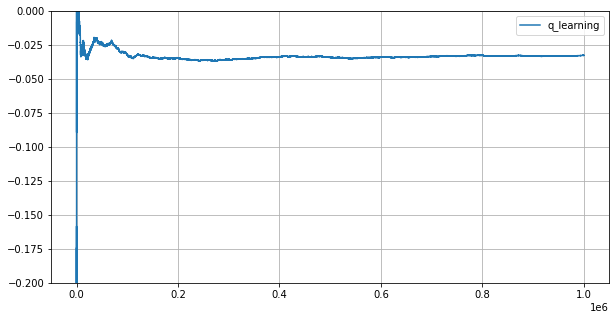

In [150]:
plt.figure(figsize=(10, 5))
plt.plot(cum_average_reward, label="q_learning")
plt.ylim([-0.2, 0])
plt.grid()
plt.legend();